# Edge-level Transit Ridership (Load) Maps

Idea by Katelyn Stangl, execution by Drew Levitt.

Given a transit system's General Transit Feed Specification (GTFS) dataset and stop-to-stop ridership data, we calculate the total passenger load along each edge (pair of adjacent stops) in the transit network.

In [1]:
import pandas as pd
import networkx as nx

## Identify key trips

We use trips.txt, calendar.txt, and stop_times.txt to identify key trips - one trip each on all combinations of route and direction. These key trips will traverse all stops served by the transit network during the time period of interest - in this case, weekday AM peak (Tuesday, trips starting between 7:00 and 10:00 AM).

In [2]:
trips = pd.read_csv('BART/trips.txt')
trips

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,trip_load_information,wheelchair_accessible,bikes_allowed
0,5,2021_09_13-DX-MVS-Weekday-08,964252,Daly City,1,NaN,964252_shp,NaN,0,0
1,6,2021_09_13-DX-MVS-Weekday-08,964395,Berryessa/North San Jose,0,NaN,964395_shp,NaN,0,0
2,5,2021_09_13-DX-MVS-Weekday-08,966804,Daly City,1,NaN,966804_shp,NaN,0,0
3,6,2021_09_13-DX-MVS-Weekday-08,966746,Berryessa/North San Jose,0,NaN,966746_shp,NaN,0,0
4,5,2021_09_13-DX-MVS-Weekday-08,964200,Daly City,1,NaN,964252_shp,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...
2729,1,2021_09_13-SU-MVS-Sunday-31,1050391,San Francisco International Airport,1,NaN,996934_shp,NaN,1,1
2730,2,2021_09_13-SU-MVS-Sunday-31,1050399,Antioch via SFO,0,NaN,1050396_shp,NaN,1,1
2731,1,2021_09_13-SU-MVS-Sunday-31,1050476,San Francisco International Airport,1,NaN,996934_shp,NaN,1,1
2732,2,2021_09_13-SU-MVS-Sunday-31,1050443,Antioch via SFO,0,NaN,1050396_shp,NaN,1,1


In [3]:
stop_times = pd.read_csv('BART/stop_times.txt')
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled
0,964200,04:55:00,04:55:00,BERY,0,NaN,NaN,0.00
1,964200,04:59:00,04:59:00,MLPT,1,NaN,NaN,15986.19
2,964200,05:07:00,05:08:00,WARM,2,NaN,NaN,52309.20
3,964200,05:13:00,05:14:00,FRMT,3,NaN,NaN,76814.51
4,964200,05:18:00,05:18:00,UCTY,4,NaN,NaN,93751.34
...,...,...,...,...,...,...,...,...
40550,1050386,23:31:00,23:31:00,DALY,22,NaN,NaN,277112.43
40551,1050386,23:35:00,23:35:00,COLM,23,NaN,NaN,285529.07
40552,1050386,23:38:00,23:38:00,SSAN,24,NaN,NaN,295353.82
40553,1050386,23:41:00,23:41:00,SBRN,25,NaN,NaN,308200.98


In [4]:
calendar = pd.read_csv('BART/calendar.txt')
calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,2021_09_13-DX-MVS-Weekday-08,1,1,1,1,1,0,0,20211001,20220211
1,2021_09_13-SA-MVS-Saturday-12,0,0,0,0,0,1,0,20211002,20220212
2,2021_09_13-SU-MVS-Sunday-01,0,0,0,0,0,0,1,20211003,20220206
3,2021_09_13-SU-MVSs-Sunday-04,0,0,0,0,0,0,1,20211024,20211024
4,2021_09_13-SU-MVSs-Sunday-03,0,0,0,0,0,0,1,20211107,20220213
5,2021_09_13-DX19-Weekday-00,1,1,1,1,1,0,0,20211001,20220211
6,2021_09_13-DX20-Weekday-00,1,1,1,1,1,0,0,20211001,20220211
7,2021_09_13-SA19-Saturday-01,0,0,0,0,0,1,0,20211002,20220212
8,2021_09_13-SA20-Saturday-01,0,0,0,0,0,1,0,20211002,20220212
9,2021_09_13-SU19-Sunday-01,0,0,0,0,0,0,1,20211003,20220213


In [5]:
# We are interested in weekday trips. We observe that all service_ids
# active on a Tuesday contain the string "Weekday"
calendar[calendar.tuesday == 1]

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,2021_09_13-DX-MVS-Weekday-08,1,1,1,1,1,0,0,20211001,20220211
5,2021_09_13-DX19-Weekday-00,1,1,1,1,1,0,0,20211001,20220211
6,2021_09_13-DX20-Weekday-00,1,1,1,1,1,0,0,20211001,20220211


In [6]:
# Check how many trips are part of each service_id
# In the end we don't do much with this, but it's useful exploratory analysis
trips['service_id'].value_counts()

2021_09_13-DX-MVS-Weekday-08     652
2021_09_13-SA-MVS-Saturday-12    380
2021_09_13-SU-MVS-Sunday-31      195
2021_09_13-DX19-Weekday-00       181
2021_09_13-DX20-Weekday-00       179
2021_09_13-SU-MVS-Sunday-01      177
2021_09_13-SU-MVSs-Sunday-04     177
2021_09_13-SU-MVSs-Sunday-03     177
2021_09_13-SA20-Saturday-01      171
2021_09_13-SA19-Saturday-01      171
2021_09_13-SU20-Sunday-01        137
2021_09_13-SU19-Sunday-01        137
Name: service_id, dtype: int64

In [7]:
# We group the stop_times table to calculate some important metrics for each trip
time_spans = stop_times.groupby('trip_id').agg({'arrival_time': 'min', 'stop_id': 'count'})
time_spans.columns = ['start_time', 'num_stops']
time_spans

,start_time,num_stops
trip_id,,
938041,07:13:00,24
938042,08:17:00,28
938043,20:48:00,27
938044,08:47:00,28
938045,09:17:00,28
...,...,...
1050485,24:01:00,4
1050486,24:23:00,4
1050487,23:01:00,4


In [8]:
# And we join these metrics on to the original trips table
trips = trips.merge(time_spans, left_on='trip_id', right_index=True)
trips

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,trip_load_information,wheelchair_accessible,bikes_allowed,start_time,num_stops
0,5,2021_09_13-DX-MVS-Weekday-08,964252,Daly City,1,NaN,964252_shp,NaN,0,0,04:40:00,22
1,6,2021_09_13-DX-MVS-Weekday-08,964395,Berryessa/North San Jose,0,NaN,964395_shp,NaN,0,0,04:54:00,5
2,5,2021_09_13-DX-MVS-Weekday-08,966804,Daly City,1,NaN,966804_shp,NaN,0,0,04:55:00,17
3,6,2021_09_13-DX-MVS-Weekday-08,966746,Berryessa/North San Jose,0,NaN,966746_shp,NaN,0,0,05:51:00,22
4,5,2021_09_13-DX-MVS-Weekday-08,964200,Daly City,1,NaN,964252_shp,NaN,0,0,04:55:00,22
...,...,...,...,...,...,...,...,...,...,...,...,...
2729,1,2021_09_13-SU-MVS-Sunday-31,1050391,San Francisco International Airport,1,NaN,996934_shp,NaN,1,1,22:57:00,27
2730,2,2021_09_13-SU-MVS-Sunday-31,1050399,Antioch via SFO,0,NaN,1050396_shp,NaN,1,1,23:01:00,27
2731,1,2021_09_13-SU-MVS-Sunday-31,1050476,San Francisco International Airport,1,NaN,996934_shp,NaN,1,1,23:57:00,27
2732,2,2021_09_13-SU-MVS-Sunday-31,1050443,Antioch via SFO,0,NaN,1050396_shp,NaN,1,1,24:01:00,27


In [9]:
# Yes, we're using .between() to compare strings. Ugly, but it works.
# (Why not cast start_time and end_time to Timestamp? Because they sometimes
# have hours > 23, which is incompatible with Timestamp but a reasonable way
# of talking about late-night service.)
am_peak = trips[trips.service_id.str.contains('Weekday') & 
                trips.start_time.between('07:00:00', '10:00:00', inclusive='left')]
am_peak

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,trip_load_information,wheelchair_accessible,bikes_allowed,start_time,num_stops
13,6,2021_09_13-DX-MVS-Weekday-08,964414,Berryessa/North San Jose,0,NaN,966746_shp,NaN,0,0,07:05:00,22
15,6,2021_09_13-DX-MVS-Weekday-08,964410,Berryessa/North San Jose,0,NaN,966746_shp,NaN,0,0,07:20:00,22
17,6,2021_09_13-DX-MVS-Weekday-08,964403,Berryessa/North San Jose,0,NaN,966746_shp,NaN,0,0,07:35:00,22
19,6,2021_09_13-DX-MVS-Weekday-08,964396,Berryessa/North San Jose,0,NaN,966746_shp,NaN,0,0,07:50:00,22
21,6,2021_09_13-DX-MVS-Weekday-08,964399,Berryessa/North San Jose,0,NaN,966746_shp,NaN,0,0,08:05:00,22
...,...,...,...,...,...,...,...,...,...,...,...,...
876,20,2021_09_13-DX20-Weekday-00,988149,Oakland Airport,1,NaN,988106_shp,NaN,0,0,09:35:00,2
877,20,2021_09_13-DX20-Weekday-00,988150,Oakland Airport,1,NaN,988106_shp,NaN,0,0,09:41:00,2
878,20,2021_09_13-DX20-Weekday-00,988151,Oakland Airport,1,NaN,988106_shp,NaN,0,0,09:47:00,2
879,20,2021_09_13-DX20-Weekday-00,988152,Oakland Airport,1,NaN,988106_shp,NaN,0,0,09:53:00,2


In [10]:
# Here we demonstrate that all weekday AM peak trips for a given route and direction
# have the same number of stops. (If this weren't the case, there would be multiple
# rows for some route_id/direction_id combinations.) This means we can simply keep
# the first trip for each route and direction as our "key trips."
am_peak.groupby(['route_id', 'direction_id', 'num_stops'])['trip_id'].count()

route_id  direction_id  num_stops
1         1             27           12
2         0             27           12
3         0             21           12
4         1             21           12
5         1             22           12
6         0             22           12
7         1             24           12
8         0             24           12
11        1             18           12
12        0             18           12
19        0             2            29
20        1             2            30
Name: trip_id, dtype: int64

In [11]:
key_trips = am_peak.drop_duplicates(['route_id', 'direction_id'])
key_trips

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,trip_load_information,wheelchair_accessible,bikes_allowed,start_time,num_stops
13,6,2021_09_13-DX-MVS-Weekday-08,964414,Berryessa/North San Jose,0,NaN,966746_shp,NaN,0,0,07:05:00,22
22,5,2021_09_13-DX-MVS-Weekday-08,964209,Daly City,1,NaN,964252_shp,NaN,0,0,07:10:00,22
131,3,2021_09_13-DX-MVS-Weekday-08,964450,Richmond,0,NaN,964518_shp,NaN,0,0,07:14:00,21
132,4,2021_09_13-DX-MVS-Weekday-08,964585,Berryessa/North San Jose,1,NaN,964593_shp,NaN,0,0,07:03:00,21
274,1,2021_09_13-DX-MVS-Weekday-08,964601,San Francisco International Airport,1,NaN,964624_shp,NaN,0,0,07:02:00,27
275,2,2021_09_13-DX-MVS-Weekday-08,965966,Antioch,0,NaN,965962_shp,NaN,0,0,07:11:00,27
407,8,2021_09_13-DX-MVS-Weekday-08,966084,Richmond via Millbrae,0,NaN,966081_shp,NaN,0,0,07:08:00,24
414,7,2021_09_13-DX-MVS-Weekday-08,966030,San Francisco Int'l Airport + Millbrae,1,NaN,966021_shp,NaN,0,0,07:11:00,24
529,11,2021_09_13-DX-MVS-Weekday-08,964367,Daly City,1,NaN,964352_shp,NaN,0,0,07:06:00,18
530,12,2021_09_13-DX-MVS-Weekday-08,964320,Dublin/Pleasanton,0,NaN,964259_shp,NaN,0,0,07:12:00,18


## Convert key trips into a list of edges

We first select each key trip's entries in stop_times. By selecting the stop_id column and concatenating it with a off-by-one version of itself, we obtain a DataFrame of from_stop and to_stop pairs, one for each edge. We then convert this DataFrame into an edge list: a list of two-element lists corresponding to each directed edge in the network graph.

In [12]:
edges = []

for trip_id in key_trips.trip_id:
    from_stops = stop_times[stop_times.trip_id == trip_id].sort_values('stop_sequence')['stop_id']
    to_stops = from_stops.shift(-1)
    trip_edges = pd.concat([from_stops, to_stops], axis=1).dropna()
    edges.append(trip_edges)
    
edges = pd.concat(edges).drop_duplicates()
edges.columns = ['from_stop', 'to_stop']
edges

,from_stop,to_stop
4041,DALY,BALB
4042,BALB,GLEN
4043,GLEN,24TH
4044,24TH,16TH
4045,16TH,CIVC
...,...,...
2354,BAYF,CAST
2355,CAST,WDUB
2356,WDUB,DUBL
14505,OAKL,COLS


In [13]:
edge_list = [[row.from_stop, row.to_stop] for idx, row in edges.iterrows()]
edge_list

[['DALY', 'BALB'],
 ['BALB', 'GLEN'],
 ['GLEN', '24TH'],
 ['24TH', '16TH'],
 ['16TH', 'CIVC'],
 ['CIVC', 'POWL'],
 ['POWL', 'MONT'],
 ['MONT', 'EMBR'],
 ['EMBR', 'WOAK'],
 ['WOAK', 'LAKE'],
 ['LAKE', 'FTVL'],
 ['FTVL', 'COLS'],
 ['COLS', 'SANL'],
 ['SANL', 'BAYF'],
 ['BAYF', 'HAYW'],
 ['HAYW', 'SHAY'],
 ['SHAY', 'UCTY'],
 ['UCTY', 'FRMT'],
 ['FRMT', 'WARM'],
 ['WARM', 'MLPT'],
 ['MLPT', 'BERY'],
 ['BERY', 'MLPT'],
 ['MLPT', 'WARM'],
 ['WARM', 'FRMT'],
 ['FRMT', 'UCTY'],
 ['UCTY', 'SHAY'],
 ['SHAY', 'HAYW'],
 ['HAYW', 'BAYF'],
 ['BAYF', 'SANL'],
 ['SANL', 'COLS'],
 ['COLS', 'FTVL'],
 ['FTVL', 'LAKE'],
 ['LAKE', 'WOAK'],
 ['WOAK', 'EMBR'],
 ['EMBR', 'MONT'],
 ['MONT', 'POWL'],
 ['POWL', 'CIVC'],
 ['CIVC', '16TH'],
 ['16TH', '24TH'],
 ['24TH', 'GLEN'],
 ['GLEN', 'BALB'],
 ['BALB', 'DALY'],
 ['LAKE', '12TH'],
 ['12TH', '19TH'],
 ['19TH', 'MCAR'],
 ['MCAR', 'ASHB'],
 ['ASHB', 'DBRK'],
 ['DBRK', 'NBRK'],
 ['NBRK', 'PLZA'],
 ['PLZA', 'DELN'],
 ['DELN', 'RICH'],
 ['RICH', 'DELN'],
 ['DELN', 'P

## Build and traverse graph

We convert the edge list into a NetworkX `DiGraph`, a directed graph (i.e., each edge may only be traversed in the specified direction). 

(In practice, almost all transit networks are undirected; that is, if you can take transit from stop X to stop Y, you can probably also travel from stop Y to stop X. But, formally speaking, this is often not the case, especially for bus transit systems where the stop_id of a northbound stop may differ from that of the southbound stop across the street. By sticking to a directed graph, we handle this possible situation robustly.)

NetworkX includes a great `shortest_path()` function that returns the shortest path between a pair of nodes, or, if origin and destination nodes are left unspecified, returns the shortest path between *all* pairs of nodes in a graph. 

In [14]:
G = nx.DiGraph(edge_list)
paths = nx.shortest_path(G)

In [15]:
# That was too easy! Did it really work? We inspect a relatively complicated path
# (one that would require at least two transfers in the real world). It works!
paths['OAKL']['ANTC']

['OAKL',
 'COLS',
 'FTVL',
 'LAKE',
 '12TH',
 '19TH',
 'MCAR',
 'ROCK',
 'ORIN',
 'LAFY',
 'WCRK',
 'PHIL',
 'CONC',
 'NCON',
 'PITT',
 'PCTR',
 'ANTC']

## Convert paths into a table of OD pair/edge correspondences

Our task now is similar to before, when we needed to convert lists of nodes corresponding to key trips into a set of from_stop/to_stop pairs. Now we take each o_stop/d_stop pair and associate it with each edge that its shortest path traverses. The result is a DataFrame onto which we can join OD volume data in order to sum up total passenger load on each edge.

In [16]:
rows = []

for o_stop, v in paths.items():
    for d_stop, path in v.items():
        if len(path) > 1: # Skip same-stop OD pairs
            from_stops = pd.Series(path)
            to_stops = from_stops.shift(-1)
            trip_rows = pd.concat([from_stops, to_stops], axis=1).dropna()
            trip_rows['o_stop'] = o_stop
            trip_rows['d_stop'] = d_stop
            rows.append(trip_rows)
        
df = pd.concat(rows)
df.columns = ['from_stop', 'to_stop', 'o_stop', 'd_stop']
# Create an edge_id column that we can use for convenient groupby and join operations
df['edge_id'] = df['from_stop'].astype(str) + '_' + df['to_stop'].astype(str)
df = df[['o_stop', 'd_stop', 'from_stop', 'to_stop', 'edge_id']] # Reorder columns
df

,o_stop,d_stop,from_stop,to_stop,edge_id
0,DALY,BALB,DALY,BALB,DALY_BALB
0,DALY,COLM,DALY,COLM,DALY_COLM
0,DALY,GLEN,DALY,BALB,DALY_BALB
1,DALY,GLEN,BALB,GLEN,BALB_GLEN
0,DALY,SSAN,DALY,COLM,DALY_COLM
...,...,...,...,...,...
12,OAKL,MLBR,BALB,DALY,BALB_DALY
13,OAKL,MLBR,DALY,COLM,DALY_COLM
14,OAKL,MLBR,COLM,SSAN,COLM_SSAN
15,OAKL,MLBR,SSAN,SBRN,SSAN_SBRN


In [17]:
# Let's just confirm that this worked correctly (it did)
df[df.o_stop.eq('ASHB') & df.d_stop.eq('OAKL')]

,o_stop,d_stop,from_stop,to_stop,edge_id
0,ASHB,OAKL,ASHB,MCAR,ASHB_MCAR
1,ASHB,OAKL,MCAR,19TH,MCAR_19TH
2,ASHB,OAKL,19TH,12TH,19TH_12TH
3,ASHB,OAKL,12TH,LAKE,12TH_LAKE
4,ASHB,OAKL,LAKE,FTVL,LAKE_FTVL
5,ASHB,OAKL,FTVL,COLS,FTVL_COLS
6,ASHB,OAKL,COLS,OAKL,COLS_OAKL


## Prepare to import BART ridership data

These cells are specific to BART, which (admirably) releases monthly ridership data in a useful station-to-station matrix format but (annoyingly) uses two-digit station codes in those ridership reports instead of the four-digit station codes used in their GTFS data. We generate a correspondence table mostly automatically, but with some manual cleanup outside this notebook.

In [18]:
stops = pd.read_csv('BART/stops.txt')
stops

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,plc_url,location_type,parent_station
0,LAKE,NaN,Lake Merritt,NaN,37.797322,-122.265247,LAKE,NaN,0,place_LAKE
1,FTVL,NaN,Fruitvale,NaN,37.774841,-122.224081,FTVL,NaN,0,place_FTVL
2,COLS,NaN,Coliseum,NaN,37.753576,-122.196716,COLS,NaN,0,place_COLS
3,SANL,NaN,San Leandro,NaN,37.721784,-122.160740,SANL,NaN,0,place_SANL
4,BAYF,NaN,Bay Fair,NaN,37.696908,-122.126446,BAYF,NaN,0,place_BAYF
...,...,...,...,...,...,...,...,...,...,...
177,PITT_1,NaN,Enter/Exit : Station entrance (South),Station entrance (South),38.018237,-121.945339,NaN,NaN,2,place_PITT
178,DELN_1,NaN,Enter/Exit : Station entrance (North),Station entrance (North),37.925323,-122.317023,NaN,NaN,2,place_DELN
179,DELN_2,NaN,Enter/Exit : Station entrance (South),Station entrance (South),37.924976,-122.316747,NaN,NaN,2,place_DELN
180,MLPT_1,NaN,Enter/Exit: Station entrance,Station entrance,37.410155,-121.890683,NaN,NaN,2,place_MLPT


In [19]:
stop_abbrs = pd.read_excel('BART/station-names.xls')
stop_abbrs = stop_abbrs.merge(stops[['stop_id', 'stop_name']], 
                              left_on='Station Name',
                              right_on='stop_name', how='outer')
stop_abbrs = stop_abbrs[stop_abbrs.columns[1:]]
stop_abbrs.to_csv('BART/stop_abbrs_orig.csv', index=False) # for manual cleanup
stop_abbrs[stop_abbrs.isnull().any(axis=1)]

,Two-Letter Station Code,Station Name,stop_id,stop_name
8,BK,Berkeley,NaN,NaN
25,BF,Bayfair,NaN,NaN
36,PH,Pleasant Hill,NaN,NaN
53,CC,Civic Center,NaN,NaN
54,16,16th Street Mission,NaN,NaN
...,...,...,...,...
190,NaN,NaN,SBRN_3,Enter/Exit : Station entrance (East)
191,NaN,NaN,SHAY_3,Enter/Exit : Station entrance (East)
192,NaN,NaN,SBRN_4,Enter/Exit : Station entrance (West)
193,NaN,NaN,MLPT_1,Enter/Exit: Station entrance


In [20]:
stop_abbrs = pd.read_csv('BART/stop_abbrs.csv') # Read in the hand-polished table
stop_abbrs

,short_id,stop_id,stop_name
0,12,12TH,12th Street / Oakland City Center
1,16,16TH,16th Street / Mission
2,19,19TH,19th Street Oakland
3,24,24TH,24th Street / Mission
4,AN,ANTC,Antioch
5,AS,ASHB,Ashby
6,BP,BALB,Balboa Park
7,BF,BAYF,Bay Fair
8,BE,BERY,Berryessa / North San Jose
9,CV,CAST,Castro Valley


## Join ridership data to OD/edge table

Now we read in some BART ridership data (in wide format), melt it into long format, and join it to the OD pair/edge correspondence table. Then, grouping the resulting DataFrame by edge_id, we obtain edge-level transit ridership!

From https://www.bart.gov/about/reports/ridership:
    
> Here's how to read the data: If you look across the top of the page, each station listed in Row 2 is the station of entry. Look down Column A to find the station of exit. So, for example, on the typical weekday in July 2010, 399 people entered at Richmond Station and traveled to Berkeley Station. And, heading in the opposite direction, 374 people entered at Berkeley Station and traveled to Richmond Station. Easy!

Easy, and dumb. This means the origins are on the columns and the destinations are on the rows, which is the opposite of the normal convention. Fortunately, `df.T` (transpose) will take care of this.

In [21]:
jan_2020 = pd.read_excel('BART/ridership_2020/Ridership_202001.xlsx', skiprows=1)
jan_2020 = jan_2020.set_index(jan_2020.columns[0]).T
jan_2020 = jan_2020.dropna().iloc[:-1, :-1] # Last row and column are unnecessary totals
jan_2020.index.name = 'o_short_id'
jan_2020.columns.name = 'd_short_id'
jan_2020

d_short_id,RM,EN,EP,NB,BK,AS,MA,19,12,LM,...,SB,SO,MB,WD,OA,WS,ML,BE,PC,AN
o_short_id,,,,,,,,,,,,,,,,,,,,,
RM,19.857143,131.142857,87.523810,70.095238,436.761905,95.857143,155.476190,181.285714,204.380952,38.952381,...,25.333333,47.666667,22.666667,6.952381,7.666667,17.666667,0.0,0.0,9.095238,10.571429
EN,119.523810,21.761905,80.285714,76.190476,763.761905,115.904762,241.714286,461.523810,562.952381,77.666667,...,35.523810,107.952381,67.666667,10.666667,24.666667,41.428571,0.0,0.0,5.952381,11.238095
EP,86.619048,89.142857,11.952381,49.476190,641.428571,75.761905,127.238095,293.476190,324.238095,51.142857,...,12.952381,56.333333,30.047619,7.523810,22.238095,24.142857,0.0,0.0,3.095238,4.571429
NB,70.238095,85.047619,56.619048,11.333333,204.047619,57.857143,86.523810,260.857143,267.095238,45.142857,...,8.238095,70.380952,31.666667,3.857143,21.666667,23.809524,0.0,0.0,2.476190,5.047619
BK,389.523810,707.190476,635.238095,193.714286,41.619048,289.095238,335.809524,484.000000,417.333333,200.904762,...,29.285714,103.142857,116.619048,39.000000,41.095238,141.047619,0.0,0.0,21.714286,45.428571
AS,93.476190,122.000000,77.047619,55.523810,313.047619,15.047619,100.476190,256.523810,243.761905,66.095238,...,14.571429,48.142857,35.476190,10.333333,16.476190,29.571429,0.0,0.0,4.857143,10.523810
MA,140.000000,249.571429,133.523810,95.333333,351.000000,98.904762,49.857143,215.904762,255.571429,66.619048,...,24.428571,94.095238,61.285714,25.238095,21.380952,63.000000,0.0,0.0,48.000000,102.666667
19,168.619048,433.428571,288.904762,247.476190,533.809524,258.476190,220.952381,34.809524,56.714286,36.428571,...,62.333333,87.857143,127.380952,114.333333,30.952381,215.476190,0.0,0.0,51.333333,122.047619
12,183.047619,559.190476,335.523810,256.523810,488.523810,258.904762,268.285714,64.476190,48.428571,34.047619,...,79.904762,105.523810,137.285714,134.571429,44.190476,199.761905,0.0,0.0,57.238095,168.666667


In [22]:
jan_2020 = jan_2020.melt(value_name='trips', ignore_index=False).reset_index()
# Cast these short_ids to string so they will properly match stop_abbrs
jan_2020['o_short_id'] = jan_2020['o_short_id'].astype(str)
jan_2020['d_short_id'] = jan_2020['d_short_id'].astype(str)
jan_2020

,o_short_id,d_short_id,trips
0,RM,RM,19.857143
1,EN,RM,119.523810
2,EP,RM,86.619048
3,NB,RM,70.238095
4,BK,RM,389.523810
...,...,...,...
2495,WS,AN,11.428571
2496,ML,AN,0.000000
2497,BE,AN,0.000000
2498,PC,AN,19.904762


In [23]:
jan_2020 = jan_2020.merge(stop_abbrs[['short_id', 'stop_id']], left_on='o_short_id', right_on='short_id')
jan_2020 = jan_2020.merge(stop_abbrs[['short_id', 'stop_id']], left_on='d_short_id', right_on='short_id',
                          suffixes=['_o', '_d'])
jan_2020

,o_short_id,d_short_id,trips,short_id_o,stop_id_o,short_id_d,stop_id_d
0,RM,RM,19.857143,RM,RICH,RM,RICH
1,EN,RM,119.523810,EN,DELN,RM,RICH
2,EP,RM,86.619048,EP,PLZA,RM,RICH
3,NB,RM,70.238095,NB,NBRK,RM,RICH
4,BK,RM,389.523810,BK,DBRK,RM,RICH
...,...,...,...,...,...,...,...
2495,WS,AN,11.428571,WS,WARM,AN,ANTC
2496,ML,AN,0.000000,ML,MLPT,AN,ANTC
2497,BE,AN,0.000000,BE,BERY,AN,ANTC
2498,PC,AN,19.904762,PC,PCTR,AN,ANTC


In [24]:
jan_2020 = jan_2020[['stop_id_o', 'stop_id_d', 'trips']]
jan_2020.columns = ['o_stop', 'd_stop', 'trips']
jan_2020

,o_stop,d_stop,trips
0,RICH,RICH,19.857143
1,DELN,RICH,119.523810
2,PLZA,RICH,86.619048
3,NBRK,RICH,70.238095
4,DBRK,RICH,389.523810
...,...,...,...
2495,WARM,ANTC,11.428571
2496,MLPT,ANTC,0.000000
2497,BERY,ANTC,0.000000
2498,PCTR,ANTC,19.904762


In [25]:
jan_2020_edges = df.merge(jan_2020).groupby('edge_id')['trips'].sum()
jan_2020_edges

edge_id
12TH_19TH     70929.523810
12TH_LAKE     11412.238095
12TH_WOAK     62908.238095
16TH_24TH     49224.000000
16TH_CIVC     61179.761905
                 ...      
WDUB_CAST     10982.571429
WDUB_DUBL      7682.000000
WOAK_12TH     64071.238095
WOAK_EMBR    108172.285714
WOAK_LAKE     38714.714286
Name: trips, Length: 102, dtype: float64

## Visualize!

This is sort of a TODO area - I'd like to use Leaflet or Plotly or something cool to prepare an interactive map within the notebook, or else use ArcPy or whatnot to procedurally join the results onto a feature class. But for now, I just kick out the edges and nodes to CSV for visualization in [flowmap.blue](https://flowmap.blue). It works pretty well! 

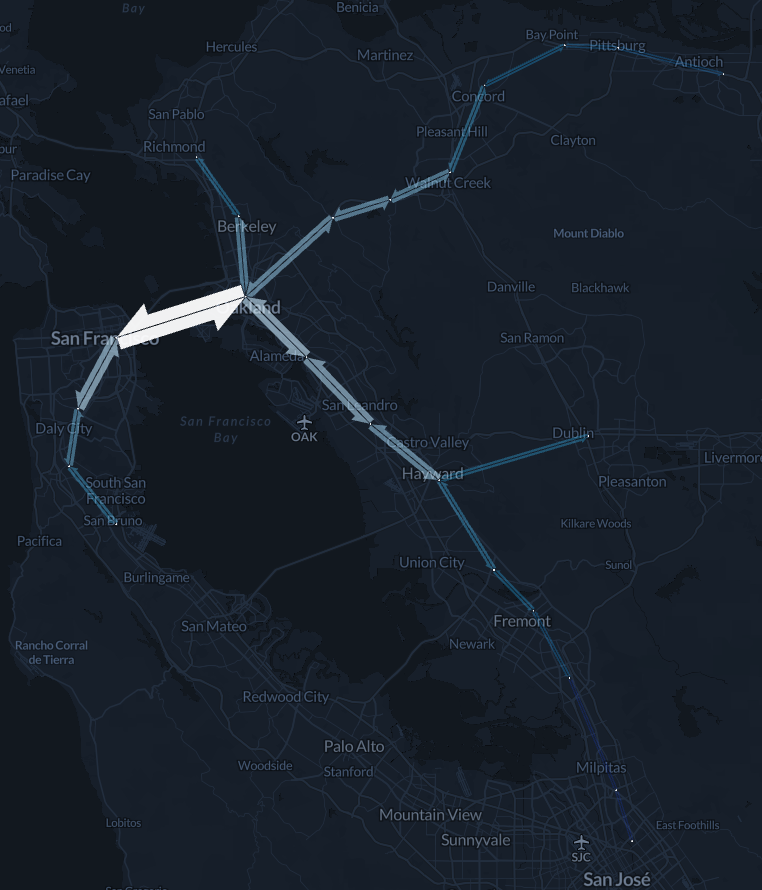

In [26]:
edges_flowmap = df.merge(jan_2020).groupby(['from_stop', 'to_stop'])['trips'].sum().reset_index()
edges_flowmap.columns = ['origin', 'dest', 'count']
edges_flowmap.to_csv('flows_flowmap.csv', index=False)
edges_flowmap

,origin,dest,count
0,12TH,19TH,70929.523810
1,12TH,LAKE,11412.238095
2,12TH,WOAK,62908.238095
3,16TH,24TH,49224.000000
4,16TH,CIVC,61179.761905
...,...,...,...
97,WDUB,CAST,10982.571429
98,WDUB,DUBL,7682.000000
99,WOAK,12TH,64071.238095
100,WOAK,EMBR,108172.285714


In [27]:
stops_flowmap = stops.loc[stops.zone_id.notna(), ['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]
stops_flowmap.columns = ['id', 'name', 'lat', 'lon']
stops_flowmap.to_csv('stops_flowmap.csv', index=False)
stops_flowmap

,id,name,lat,lon
0,LAKE,Lake Merritt,37.797322,-122.265247
1,FTVL,Fruitvale,37.774841,-122.224081
2,COLS,Coliseum,37.753576,-122.196716
3,SANL,San Leandro,37.721784,-122.160740
4,BAYF,Bay Fair,37.696908,-122.126446
5,HAYW,Hayward,37.669699,-122.086958
6,SHAY,South Hayward,37.634340,-122.057182
7,UCTY,Union City,37.590735,-122.017248
8,FRMT,Fremont,37.557480,-121.976619
9,ROCK,Rockridge,37.844755,-122.251235
